## Installs

In [1]:
# %%
!pip uninstall -y mediapipe || true
!pip install -U "numpy>=2.0,<2.3" pandas scikit-learn pillow tqdm opencv-python matplotlib


## Extract Datasets

In [2]:
# %%
from pathlib import Path
import zipfile, sys, shutil
from tqdm import tqdm

BASE = Path.cwd()
RAW  = BASE / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

# --- Find ZIPs heuristically ---
zips = list((BASE / "data").glob("*.zip"))
if not zips:
    raise SystemExit("No .zip files found in the current folder. Put the two zips here and re-run.")

def pick_zip(zips, must_contain):
    must = must_contain.lower()
    for z in zips:
        name = z.name.lower()
        if all(x in name for x in must.split()):
            return z
    return None

aff_zip = pick_zip(zips, "affec 256") or pick_zip(zips, "Affectnet_256") or pick_zip(zips, "affect 256")
raf_zip = pick_zip(zips, "raf") or pick_zip(zips, "RAF-DB") or pick_zip(zips, "rafdb")

if not aff_zip or not raf_zip:
    print("I found these ZIPs:\n - " + "\n - ".join(z.name for z in zips))
    raise SystemExit(
        "\nCould not auto-detect both archives.\n"
        "Rename your files so one contains 'affec' and '256', and the other contains 'raf', then re-run."
    )

print(f"AffectNet ZIP → {aff_zip.name}")
print(f"RAF-DB   ZIP → {raf_zip.name}")

# --- Extract helpers ---
def extract_all(zip_path: Path, dest: Path):
    if dest.exists() and any(dest.iterdir()):
        print(f"Already extracted: {dest}")
        return dest
    dest.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        members = zf.infolist()
        for m in tqdm(members, desc=f"Extracting {zip_path.name}", unit="file"):
            zf.extract(m, dest)
    return dest

AFF_DIR = RAW / "affectnet256"
RAF_DIR = RAW / "rafdb"

extract_all(aff_zip, AFF_DIR)
extract_all(raf_zip, RAF_DIR)

# Quick probe: count images we can see inside each extracted tree
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
def count_images(root: Path):
    return sum(1 for p in root.rglob("*") if p.suffix.lower() in IMG_EXTS)

print("\nFound counts after extraction:")
print(" - AffectNet-256 images:", count_images(AFF_DIR))
print(" - RAF-DB images:",      count_images(RAF_DIR))

# Show shallow directory listings to help us confirm structure
def peek(root: Path, depth=2, max_items=10):
    print(f"\nPeek: {root}")
    shown = 0
    for p in root.rglob("*"):
        rel = p.relative_to(root)
        if len(rel.parts) <= depth:
            print("  ", rel)
            shown += 1
            if shown >= max_items:
                print("  ...")
                break

peek(AFF_DIR)
peek(RAF_DIR)


AffectNet ZIP → Affectnet_256.zip
RAF-DB   ZIP → RAF-DB.zip
Already extracted: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\raw\affectnet256
Already extracted: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\raw\rafdb

Found counts after extraction:
 - AffectNet-256 images: 33803
 - RAF-DB images: 15339

Peek: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\raw\affectnet256
   Affectnet Resize 256
   Affectnet Resize 256\JPEG

Peek: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\raw\rafdb
   DATASET
   test_labels.csv
   train_labels.csv
   DATASET\test
   DATASET\train


## Check Affecnet Labels

In [3]:
# %%
import re
import pandas as pd
from pathlib import Path

AFF_IMG_DIR = AFF_DIR / "Affectnet Resize 256" / "JPEG"

# Our target 7-class scheme
label_map = {
    "neutral": "neutral",
    "happy": "happy",
    "sad": "sad",
    "angry": "angry",
    "anger": "angry",
    "fear": "fear",
    "disgust": "disgust",
    "surprise": "surprise",
    "contempt": "contempt"  # optional, we might drop later
}

rows = []
for img_path in AFF_IMG_DIR.glob("*.*"):
    fname = img_path.stem.lower()  # filename without extension
    # Extract the first word (label prefix)
    m = re.match(r"([a-z]+)[\-_]?", fname)
    if not m:
        continue
    raw_label = m.group(1)
    if raw_label in label_map:
        rows.append({
            "filepath": str(img_path.resolve()),
            "label": label_map[raw_label],
            "source": "affectnet"
        })
    else:
        # catch any strange labels
        rows.append({
            "filepath": str(img_path.resolve()),
            "label": "unknown",
            "source": "affectnet"
        })

aff_df = pd.DataFrame(rows)
print("AffectNet parsed:", aff_df.shape)
print("Label distribution:\n", aff_df['label'].value_counts())

# Save CSV
AFF_CSV = BASE / "data" / "affectnet_labels.csv"
aff_df.to_csv(AFF_CSV, index=False)
print("\nSaved:", AFF_CSV)


AffectNet parsed: (33803, 3)
Label distribution:
 label
angry       5000
fear        5000
happy       5000
sad         5000
neutral     5000
surprise    5000
disgust     3803
Name: count, dtype: int64

Saved: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\affectnet_labels.csv


## Check RAF-DB Labels

In [4]:
# %%
import pandas as pd

RAF_ROOT = RAF_DIR / "DATASET"

train_csv = RAF_DIR / "train_labels.csv"
test_csv  = RAF_DIR / "test_labels.csv"

train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

print("Train shape:", train_df.shape)
print("Test shape:",  test_df.shape)
print("Columns:", train_df.columns.tolist())
print("\nFirst few rows:\n", train_df.head())

# Label mapping for RAF-DB
raf_map = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral"
}

def process_raf(df, split):
    rows = []
    for _, r in df.iterrows():
        img_path = RAF_ROOT / split / r['image']  # <-- use 'image' column
        rows.append({
            "filepath": str(img_path.resolve()),
            "label": raf_map[r['label']],          # <-- use 'label' column
            "source": f"rafdb_{split}"
        })
    return pd.DataFrame(rows)

raf_train = process_raf(train_df, "train")
raf_test  = process_raf(test_df, "test")
raf_df = pd.concat([raf_train, raf_test], ignore_index=True)

print("RAF total:", raf_df.shape)
print("Label distribution:\n", raf_df['label'].value_counts())

RAF_CSV = BASE / "data" / "rafdb_labels.csv"
raf_df.to_csv(RAF_CSV, index=False)
print("\nSaved:", RAF_CSV)


Train shape: (12271, 2)
Test shape: (3068, 2)
Columns: ['image', 'label']

First few rows:
                      image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5
RAF total: (15339, 3)
Label distribution:
 label
happy       5957
neutral     3204
sad         2460
surprise    1619
disgust      877
angry        867
fear         355
Name: count, dtype: int64

Saved: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\rafdb_labels.csv


## Normalize RAF-DB

In [5]:
# %%
import pandas as pd

RAF_ROOT = RAF_DIR / "DATASET"

raf_map = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral"
}

def process_raf(df, split):
    rows = []
    for _, r in df.iterrows():
        class_id = r['label']  # numeric 1–7
        img_file = r['image']
        # RAF-DB actually stores images in subfolders per label number
        img_path = RAF_ROOT / split / str(class_id) / img_file
        rows.append({
            "filepath": str(img_path.resolve()),
            "label": raf_map[class_id],
            "source": f"rafdb_{split}"
        })
    return pd.DataFrame(rows)

# Rebuild RAF-DB dataframe
train_df = pd.read_csv(RAF_DIR / "train_labels.csv")
test_df  = pd.read_csv(RAF_DIR / "test_labels.csv")

raf_train = process_raf(train_df, "train")
raf_test  = process_raf(test_df, "test")
raf_df = pd.concat([raf_train, raf_test], ignore_index=True)

print("RAF total:", raf_df.shape)
print("Label distribution:\n", raf_df['label'].value_counts())

RAF_CSV = BASE / "data" / "rafdb_labels.csv"
raf_df.to_csv(RAF_CSV, index=False)
print("\nSaved:", RAF_CSV)


RAF total: (15339, 3)
Label distribution:
 label
happy       5957
neutral     3204
sad         2460
surprise    1619
disgust      877
angry        867
fear         355
Name: count, dtype: int64

Saved: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\rafdb_labels.csv


## Merge RAF-DB and AFFECNET

In [6]:
# %%
import pandas as pd

# Load our two CSVs
aff_df = pd.read_csv(BASE / "data" / "affectnet_labels.csv")
raf_df = pd.read_csv(BASE / "data" / "rafdb_labels.csv")

# Combine
master_df = pd.concat([aff_df, raf_df], ignore_index=True)

print("Total images:", master_df.shape[0])
print("Label distribution:\n", master_df['label'].value_counts())

# Save master CSV
MASTER_CSV = BASE / "data" / "master_labels.csv"
master_df.to_csv(MASTER_CSV, index=False)
print("\nSaved:", MASTER_CSV)


Total images: 49142
Label distribution:
 label
happy       10957
neutral      8204
sad          7460
surprise     6619
angry        5867
fear         5355
disgust      4680
Name: count, dtype: int64

Saved: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\master_labels.csv


## Visual Sanity Check

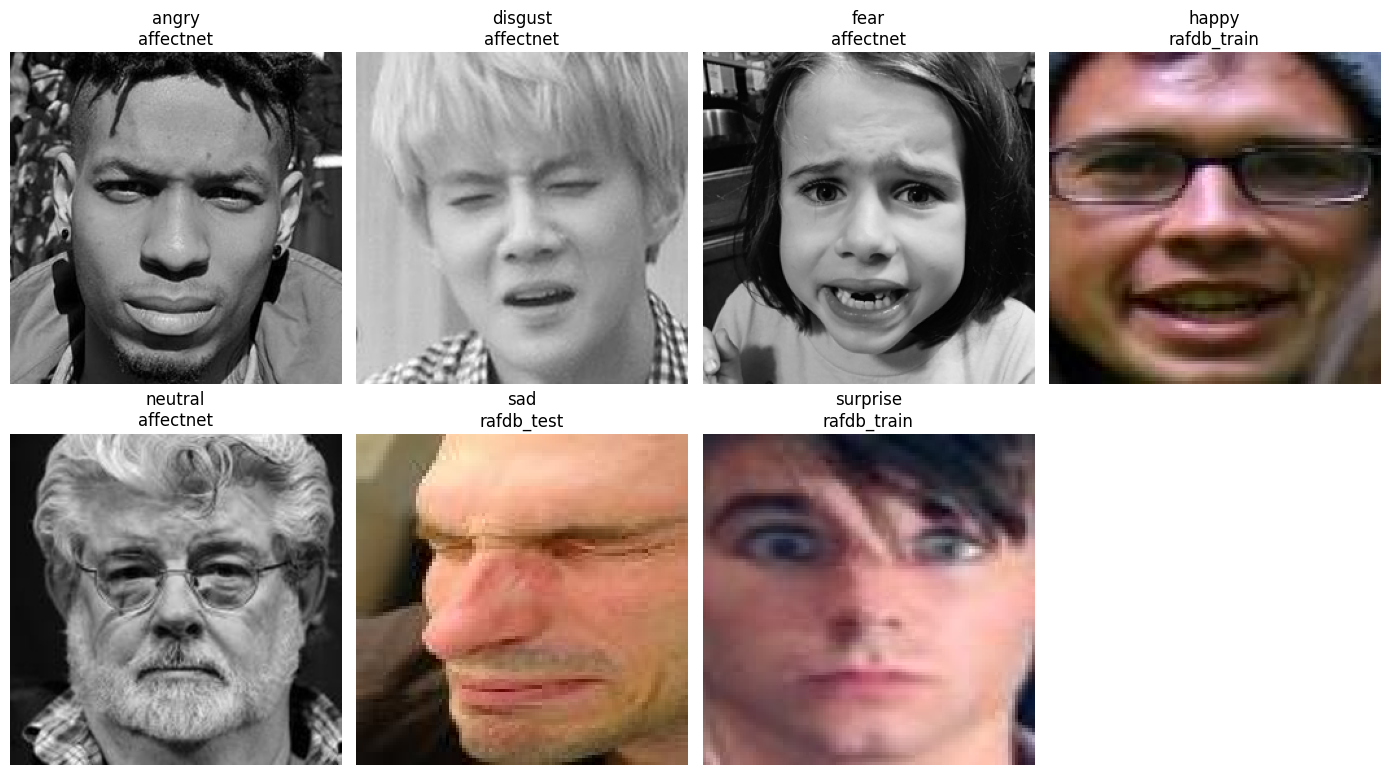

In [7]:
# %%
import matplotlib.pyplot as plt
import cv2
import random

df = master_df.copy()
classes = df['label'].unique()

plt.figure(figsize=(14, 8))

for i, cls in enumerate(classes, 1):
    subset = df[df['label'] == cls]
    row = subset.sample(1).iloc[0]
    img = cv2.imread(row['filepath'])
    if img is None:
        print("⚠️ Could not read:", row['filepath'])
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 4, i)
    plt.imshow(img)
    plt.title(f"{cls}\n{row['source']}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Create Train-Test Split

In [8]:
# %%
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Reload master dataframe
master_df = pd.read_csv(BASE / "data" / "master_labels.csv")

# ---- Splitting strategy ----
# Keep RAF's official split, but further divide AffectNet into 80/10/10
aff_df = master_df[master_df['source'].str.contains("affectnet")].copy()
raf_df = master_df[master_df['source'].str.contains("rafdb")].copy()

# Stratified split AffectNet
train_aff, temp_aff = train_test_split(
    aff_df, test_size=0.2, stratify=aff_df['label'], random_state=42
)
val_aff, test_aff = train_test_split(
    temp_aff, test_size=0.5, stratify=temp_aff['label'], random_state=42
)

# RAF already has train/test, we’ll just call their “train” → train and their “test” → test
train_raf = raf_df[raf_df['source'].str.contains("rafdb_train")].copy()
test_raf  = raf_df[raf_df['source'].str.contains("rafdb_test")].copy()

# Merge
train_df = pd.concat([train_aff, train_raf], ignore_index=True)
val_df   = val_aff
test_df  = pd.concat([test_aff, test_raf], ignore_index=True)

print("Split sizes:")
print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)

# ---- Normalize images to one clean folder ----
PROC_DIR = BASE / "data" / "processed"
for split in ["train", "val", "test"]:
    (PROC_DIR / split).mkdir(parents=True, exist_ok=True)

def process_and_copy(df, split):
    rows = []
    for i, r in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split}"):
        img = cv2.imread(r['filepath'])
        if img is None:
            continue
        # Convert grayscale → RGB
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to 224×224
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

        # Save into processed dir
        out_name = f"{split}_{i}.jpg"
        out_path = PROC_DIR / split / out_name
        cv2.imwrite(str(out_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        rows.append({
            "filepath": str(out_path.resolve()),
            "label": r['label'],
            "source": r['source']
        })
    return pd.DataFrame(rows)

proc_train = process_and_copy(train_df, "train")
proc_val   = process_and_copy(val_df,   "val")
proc_test  = process_and_copy(test_df,  "test")

# Save splits
proc_train.to_csv(PROC_DIR / "train.csv", index=False)
proc_val.to_csv(PROC_DIR / "val.csv", index=False)
proc_test.to_csv(PROC_DIR / "test.csv", index=False)

print("\nSaved processed splits in:", PROC_DIR)


Split sizes:
Train: (39313, 3)
Val:   (3380, 3)
Test:  (6449, 3)


Processing test: 100%|██████████| 6449/6449 [00:10<00:00, 642.24it/s]


Saved processed splits in: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\processed


## Check for CUDA and Class Weights

In [9]:
# %% Verify GPU and compute class weights
import torch, pandas as pd, json
from pathlib import Path
from collections import Counter

BASE = Path.cwd()
PROC_DIR = BASE / "data" / "processed"

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Our final class order (fixed everywhere)
CLASSES = ['neutral','happy','sad','angry','fear','disgust','surprise']
cls_to_idx = {c:i for i,c in enumerate(CLASSES)}
print("\nClass index mapping:", cls_to_idx)

train_df = pd.read_csv(PROC_DIR / "train.csv")
counts = Counter(train_df['label'])
print("\nTrain counts:", dict(counts))

# Inverse-frequency weights: w_c = N / (K * n_c)
N = sum(counts.values())
K = len(CLASSES)
weights = [N / (K * counts[c]) for c in CLASSES]
print("\nClass weights (in CLASSES order):", [round(w,4) for w in weights])

# Save for later cells
with open(PROC_DIR / "class_info.json", "w") as f:
    json.dump({"classes": CLASSES, "weights": weights}, f, indent=2)
print("\nSaved:", PROC_DIR / "class_info.json")


Torch: 2.8.0+cu129
CUDA available: True
GPU: NVIDIA GeForce RTX 5080

Class index mapping: {'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3, 'fear': 4, 'disgust': 5, 'surprise': 6}

Train counts: {'angry': 4705, 'happy': 8772, 'surprise': 5290, 'disgust': 3759, 'fear': 4281, 'neutral': 6524, 'sad': 5982}

Class weights (in CLASSES order): [0.8608, 0.6402, 0.9388, 1.1937, 1.3119, 1.4941, 1.0617]

Saved: c:\Users\Plazor\Documents\Code\HumanExpressionRecognition\data\processed\class_info.json


## Prepare Training Batches

In [10]:
# %%
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd, json

# Load class info
with open(PROC_DIR / "class_info.json") as f:
    info = json.load(f)
CLASSES, CLASS_WEIGHTS = info["classes"], torch.tensor(info["weights"], dtype=torch.float32).cuda()
cls_to_idx = {c:i for i,c in enumerate(CLASSES)}

# Transforms
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class FaceDataset(Dataset):
    def __init__(self, csv_path, transform):
        df = pd.read_csv(csv_path)
        self.paths = df['filepath'].tolist()
        self.labels = [cls_to_idx[l] for l in df['label']]
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.labels[i]

train_ds = FaceDataset(PROC_DIR / "train.csv", train_tfms)
val_ds   = FaceDataset(PROC_DIR / "val.csv", val_tfms)
test_ds  = FaceDataset(PROC_DIR / "test.csv", val_tfms)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

print("Train batches:", len(train_dl), "Val batches:", len(val_dl), "Test batches:", len(test_dl))


Train batches: 308 Val batches: 27 Test batches: 51


## Prepare the Model

In [11]:
# %%
import timm
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load EfficientNet-B3
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=len(CLASSES))
model = model.to(device)

# Loss
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)

# Optimizer & scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
steps_per_epoch = len(train_dl)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, epochs=30, steps_per_epoch=steps_per_epoch
)

print("Model ready:", sum(p.numel() for p in model.parameters())/1e6, "M parameters")


c:\Users\Plazor\anaconda3\envs\FaceExpressions\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model ready: 10.706991 M parameters


## Training

C:\Users\Plazor\AppData\Local\Temp\ipykernel_8580\2424012887.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train batches: 308 Val batches: 27 Test batches: 51


Epoch 1/30 [Train]:   0%|          | 0/308 [00:00<?, ?it/s]C:\Users\Plazor\AppData\Local\Temp\ipykernel_8580\2424012887.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y).to(device)
C:\Users\Plazor\AppData\Local\Temp\ipykernel_8580\2424012887.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Plazor\AppData\Local\Temp\ipykernel_8580\2424012887.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y).to(device)
C:\Users\Plazor\AppData\Local\Temp\ipykernel_8580\2424012887.py:92: FutureWarning: `torc

Epoch 1: Train Loss 1.3828 Acc 56.56% | Val Loss 1.3214 Acc 57.13% | Val Macro-F1 0.5702
✅ New best model saved @ epoch 1 (F1=0.5702)


Epoch 2: Train Loss 1.2056 Acc 65.82% | Val Loss 1.3110 Acc 57.28% | Val Macro-F1 0.5705
✅ New best model saved @ epoch 2 (F1=0.5705)


Epoch 3: Train Loss 1.1441 Acc 68.74% | Val Loss 1.2788 Acc 58.93% | Val Macro-F1 0.5901
✅ New best model saved @ epoch 3 (F1=0.5901)


Epoch 4: Train Loss 1.0939 Acc 71.01% | Val Loss 1.2977 Acc 59.79% | Val Macro-F1 0.5957
✅ New best model saved @ epoch 4 (F1=0.5957)


Epoch 5: Train Loss 1.0550 Acc 72.96% | Val Loss 1.2691 Acc 59.41% | Val Macro-F1 0.5908


Epoch 6: Train Loss 1.0123 Acc 74.87% | Val Loss 1.2800 Acc 60.06% | Val Macro-F1 0.6019
✅ New best model saved @ epoch 6 (F1=0.6019)


Epoch 7: Train Loss 0.9700 Acc 76.83% | Val Loss 1.2904 Acc 59.67% | Val Macro-F1 0.5974


Epoch 8: Train Loss 0.9265 Acc 79.01% | Val Loss 1.3370 Acc 59.17% | Val Macro-F1 0.5935


Epoch 9: Train Loss 0.8809 Acc 81.35% | Val Loss 1.3931 Acc 57.78% | Val Macro-F1 0.5742


Epoch 10: Train Loss 0.8276 Acc 83.66% | Val Loss 1.4454 Acc 56.69% | Val Macro-F1 0.5669


Epoch 11: Train Loss 0.7841 Acc 85.87% | Val Loss 1.4215 Acc 59.08% | Val Macro-F1 0.5897
⏹ Early stopping at epoch 11

Training complete. Best F1=0.6019 at epoch 6


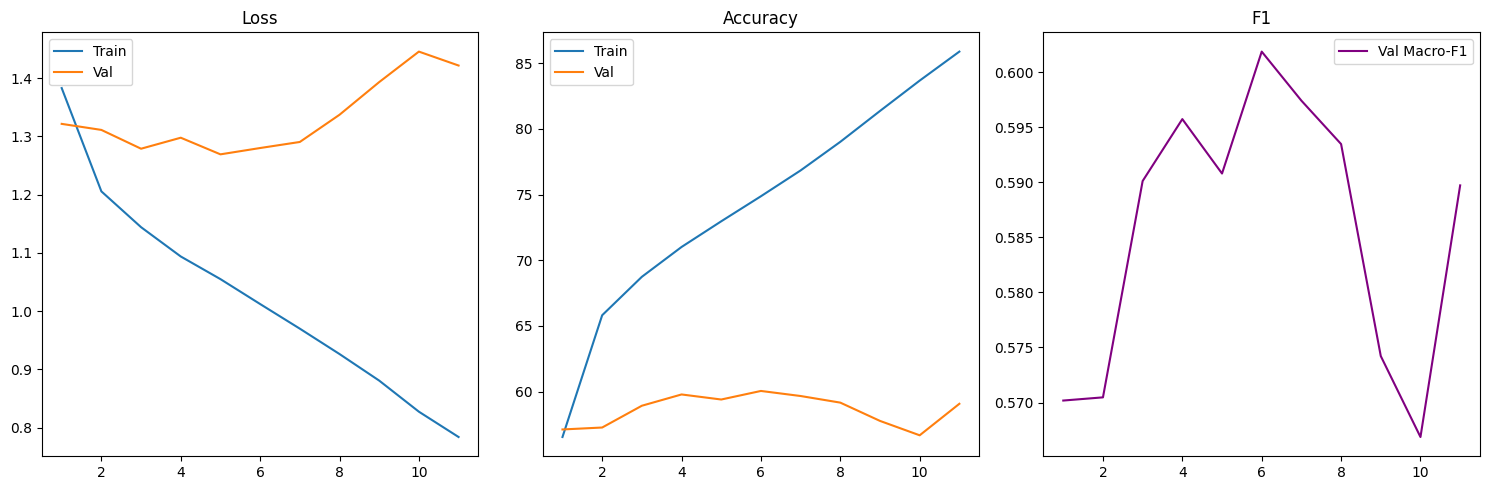

In [14]:
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# --- Config ---
DRY_RUN = False
EPOCHS = 30 if not DRY_RUN else 1
PATIENCE = 5
CKPT_DIR = PROC_DIR / "checkpoints"
CKPT_DIR.mkdir(exist_ok=True)

# --- DataLoaders with stronger augmentation ---
from torchvision import transforms
from torch.utils.data import DataLoader

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.2), ratio=(0.3,3.3))
])
val_tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# (Assuming train_ds/val_ds/test_ds are custom datasets with transform override:)
train_ds.transform = train_tfms
val_ds.transform   = val_tfms
test_ds.transform  = val_tfms

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0, pin_memory=True)

print("Train batches:", len(train_dl), "Val batches:", len(val_dl), "Test batches:", len(test_dl))

# --- Model with dropout head ---
num_classes = len(CLASSES)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)
).to(device)

# --- Training setup ---
scaler = torch.cuda.amp.GradScaler()
f1_metric = MulticlassF1Score(num_classes=num_classes, average="macro").to(device)

criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS, label_smoothing=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_f1, best_epoch, patience_counter = 0.0, 0, 0
train_losses, val_losses, train_accs, val_accs, val_f1s = [], [], [], [], []

for epoch in range(1, EPOCHS+1):
    # ---- Training ----
    model.train()
    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False)
    for x, y in pbar:
        x, y = x.to(device), torch.tensor(y).to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    train_acc = 100*correct/total
    train_loss = total_loss/total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    f1_metric.reset()
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), torch.tensor(y).to(device)
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            val_loss += loss.item() * x.size(0)
            preds = logits.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)
            f1_metric.update(preds, y)

    val_acc = 100*val_correct/val_total
    val_loss = val_loss/val_total
    val_f1 = f1_metric.compute().item()
    scheduler.step()

    print(f"Epoch {epoch}: "
          f"Train Loss {train_loss:.4f} Acc {train_acc:.2f}% | "
          f"Val Loss {val_loss:.4f} Acc {val_acc:.2f}% | "
          f"Val Macro-F1 {val_f1:.4f}")

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); val_accs.append(val_acc); val_f1s.append(val_f1)

    # --- Save checkpoints ---
    torch.save(model.state_dict(), CKPT_DIR / f"epoch_{epoch:02d}.pt")
    if val_f1 > best_f1:
        best_f1, best_epoch = val_f1, epoch
        patience_counter = 0
        torch.save(model.state_dict(), PROC_DIR / "best_model.pt")
        print(f"✅ New best model saved @ epoch {epoch} (F1={val_f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"⏹ Early stopping at epoch {epoch}")
            break

print(f"\nTraining complete. Best F1={best_f1:.4f} at epoch {best_epoch}")

# --- Plot results ---
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.plot(epochs, train_losses, label="Train"); plt.plot(epochs, val_losses, label="Val"); plt.title("Loss"); plt.legend()
plt.subplot(1,3,2); plt.plot(epochs, train_accs, label="Train"); plt.plot(epochs, val_accs, label="Val"); plt.title("Accuracy"); plt.legend()
plt.subplot(1,3,3); plt.plot(epochs, val_f1s, label="Val Macro-F1", color="purple"); plt.title("F1"); plt.legend()
plt.tight_layout(); plt.show()


## Normalize Data

In [19]:
pip install facenet-pytorch

  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached pillow-10.2.0-cp311-cp311-win_amd64.whl.metadata (9.9 kB)
  Using cached torch-2.2.2-cp311-cp311-win_amd64.whl.metadata (26 kB)
  Using cached torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
Using cached facenet_pytorch-2.6.0-py3-none-any.whl (1.9 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached pillow-10.2.0-cp311-cp311-win_amd64.whl (2.6 MB)
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 1.3/198.6 MB 9.6 MB/s eta 0:00:21
    --------------------------------------- 3.1/198.6 MB 8.8 MB/s eta 0:00:23
    --------------------------------------- 4.7/198.6 MB 8.7 MB/s eta 0:00:23
   - -------------------------------------- 6.0/198.6 MB 7.9 MB/s eta 0:00:25
   - -------------------------------------- 6.8/198.6 MB 7.1 MB/s eta

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\Users\\Plazor\\anaconda3\\envs\\FaceExpressions\\Lib\\site-packages\\torch-2.2.2.dist-info\\INSTALLER3oxy5za0.tmp'



In [17]:
# %%
import cv2
import numpy as np
from facenet_pytorch import MTCNN
from pathlib import Path
from tqdm import tqdm
import os

# Input CSV with image paths + labels
import pandas as pd
df = pd.read_csv(DATA_DIR / "master_labels.csv")  # has columns: filepath, label

# MTCNN detector
mtcnn = MTCNN(image_size=224, margin=20, post_process=False, device=device)

# Output directory
norm_dir = DATA_DIR / "normalized"
(norm_dir / "images").mkdir(parents=True, exist_ok=True)

def preprocess_image(img_path, save_path):
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return False
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect & align face
        face = mtcnn(img)
        if face is None:
            return False  # no face detected

        # Convert tensor → numpy, uint8
        face = face.permute(1,2,0).int().cpu().numpy()
        face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)

        # Histogram Equalization (CLAHE) on each channel
        lab = cv2.cvtColor(face, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        face = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        # Save normalized face
        cv2.imwrite(str(save_path), face)
        return True
    except Exception as e:
        return False

# Process all images
normalized_records = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    src = Path(row["filepath"])
    label = row["label"]

    dst = norm_dir / "images" / f"{i}_{label}.jpg"
    success = preprocess_image(src, dst)
    if success:
        normalized_records.append({"filepath": dst, "label": label})

# Save new CSV
norm_df = pd.DataFrame(normalized_records)
norm_df.to_csv(DATA_DIR / "normalized_labels.csv", index=False)

print(f"✅ Normalized dataset saved: {len(norm_df)} images at {norm_dir}")


^C


ModuleNotFoundError: No module named 'facenet_pytorch'

  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------- ----------------- 1.0/1.9 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 7.4 MB/s  0:00:00
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------- ----------- 1.8/2.6 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 10.1 MB/s  0:00:00
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 2.1/198.6 MB 16.8 MB/s eta 0:00:12
    --------------------------------------- 2.6/198.6 MB 5.6 MB/s eta 0:00:36
   - -------------------------------------- 5.2/198.6 MB 9.4 MB/s eta 0:00:21
   - -------------------------------------- 6.0/198.6 MB 7.0 MB/s eta 0:00:28
   - -------------------------------------- 7.

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
torchaudio 2.8.0+cu129 requires torch==2.8.0+cu129, but you have torch 2.2.2 which is incompatible.
